In [3]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [4]:
#Data Import
train_df = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:
train_df.head()

In [ ]:
train_df.tail()

In [5]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


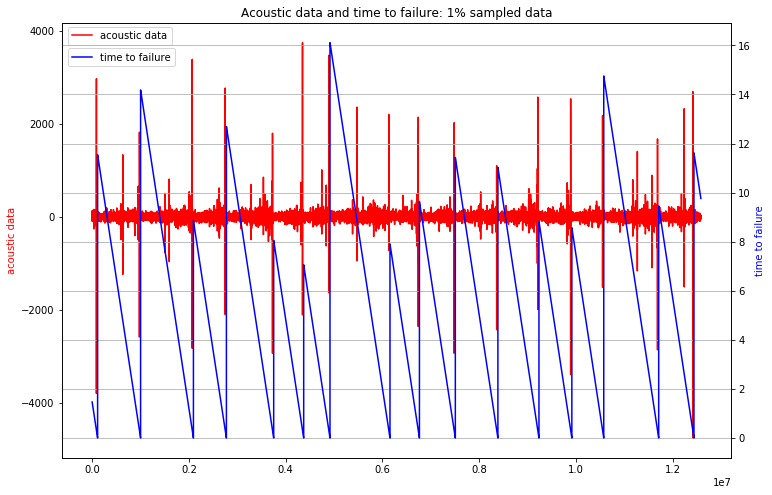

In [7]:
#Data Exploration
#Acoustic = seismic activity
#Time to Failure = Time until earthquake happens
train_ad_sample_df = train_df['acoustic_data'].values[::50]
train_ttf_sample_df = train_df['time_to_failure'].values[::50]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

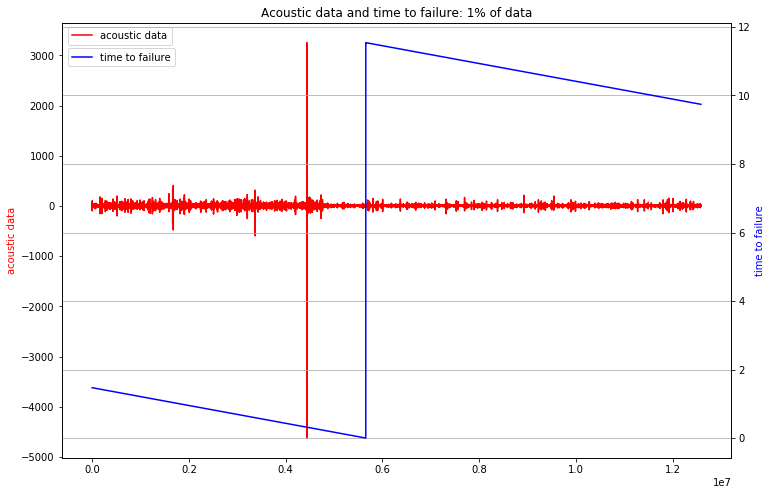

In [8]:
#Zoomed in see large seismic activity before failure
train_ad_sample_df = train_df['acoustic_data'].values[:12582909]
train_ttf_sample_df = train_df['time_to_failure'].values[:12582909]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In [9]:
#Features engineering
#There are 150,00 test segments, so split training data into the same dimension as the test data
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [10]:
#Computation Helper Funtions
#used to make your programs easier to read by giving descriptive names to computations. They also let you reuse computations, just as with functions in general.
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [11]:
#Process train file - Calculating the aggregated functions for train set
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [12]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [13]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [14]:
train_X.shape

(4194, 154)

In [15]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101106,104.0,-98.0,1.200000e+01,2349.811482,732617.0,-20121.154171,-9.701277e-16,1399.854635,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-1.704698e-06,74222.343443,5.629
1,4.725767,6.588824,181.0,-154.0,5.000000e+00,2566.032248,708865.0,-31056.675076,-1.139900e-15,1810.312266,...,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-2.449664e-06,74364.426478,5.667
2,4.906393,6.967397,140.0,-106.0,5.000000e+00,2683.549049,735959.0,-27654.557067,-2.910383e-16,1921.220576,...,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,1.140940e-06,74594.984584,5.957
3,4.902240,6.922305,197.0,-199.0,5.000000e+00,2685.788525,735336.0,-25622.393604,1.455192e-16,1891.826366,...,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-2.550336e-06,74333.143623,5.858
4,4.908720,7.301110,145.0,-126.0,1.200000e+01,2761.715771,736308.0,-26271.075117,1.212660e-16,1995.742969,...,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,1.550336e-06,74428.435969,6.078
5,4.913513,5.434111,142.0,-144.0,1.400000e+01,2420.968091,737027.0,-24168.435450,-9.701277e-17,1479.700814,...,0.293941,5.838,4.042,4.270,4.422,5.402,5.620,-3.697987e-06,74539.909434,5.838
6,4.855660,5.687823,120.0,-78.0,1.600711e-15,2437.523641,728349.0,-23876.893136,-7.275958e-16,1564.532358,...,0.219472,5.546,3.958,4.285,4.504,5.214,5.370,-1.140940e-07,74501.904751,5.546
7,4.505427,5.854512,139.0,-134.0,3.000000e+00,2361.259304,675814.0,-25427.499452,-9.701277e-16,1615.715786,...,0.218514,5.180,3.489,4.040,4.148,4.863,4.953,-1.395973e-06,74515.926219,5.180
8,4.717833,7.789643,168.0,-156.0,1.000000e+00,2805.303460,707675.0,-34542.227581,2.061521e-16,2137.915924,...,0.240917,5.717,3.933,4.158,4.315,5.104,5.337,2.221477e-06,74464.251035,5.717
9,4.730960,6.890459,152.0,-126.0,5.000000e+00,2620.173754,709644.0,-23173.271872,-1.940255e-16,1900.967780,...,0.258462,5.423,3.832,4.190,4.301,5.128,5.261,5.127517e-06,74344.216475,5.423


In [16]:
#Scale the data
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [23]:
scaled_train_X.to_csv("scaled_train_X.csv", index =False)

In [17]:
#Obtained dataframe from scalar
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.218194,0.193218,1.199316,-0.105007,1.424140,0.156736,-0.337946,-0.169052,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,0.805716,0.004734,0.063936,-0.018037,0.078886,-0.008599,0.805716,-0.222118,-0.393007,0.007212,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,1.511155,0.049252,-0.086289,0.163039,0.078886,0.043800,1.511155,-0.104254,-0.117703,0.054839,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,1.494934,0.043950,0.122560,-0.187796,0.078886,0.044798,1.494934,-0.033851,0.023881,0.042217,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,1.520242,0.088495,-0.067969,0.087590,1.199316,0.078652,1.520242,-0.056324,0.016016,0.086842,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032
5,1.538962,-0.131054,-0.078961,0.019687,1.519439,-0.073279,1.538962,0.016521,-0.054777,-0.134763,...,0.257139,0.061716,0.239714,0.699393,1.120525,1.741324,1.193167,-1.382506,0.273910,0.061716
6,1.313016,-0.101219,-0.159569,0.268667,-0.721422,-0.065898,1.313016,0.026621,-0.259288,-0.098334,...,-0.218670,-0.031134,0.204367,0.730609,1.416341,1.059323,0.627166,-0.031853,0.021835,-0.031134
7,-0.054824,-0.081617,-0.089953,0.057411,-0.241237,-0.099902,-0.054824,-0.027099,-0.337946,-0.076354,...,-0.224790,-0.147515,0.007014,0.220737,0.132067,-0.213989,-0.316925,-0.514952,0.114836,-0.147515
8,0.774732,0.145944,0.016304,-0.025582,-0.561360,0.098087,0.774732,-0.342873,0.043546,0.147895,...,-0.081653,0.023240,0.193847,0.466308,0.734522,0.660279,0.552453,0.848347,-0.227912,0.023240
9,0.825999,0.040205,-0.042321,0.087590,0.078886,0.015542,0.825999,0.050997,-0.086240,0.046142,...,0.030453,-0.070246,0.151347,0.532904,0.684017,0.747343,0.380389,1.943539,-1.024070,-0.070246


In [18]:
#Process test data - Apply the same process to test as train
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [19]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [22]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [25]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [26]:
scaled_test_X.to_csv("scaled_test_X.csv", index =False)

In [27]:
scaled_test_X.shape

(2624, 154)

In [28]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081635,-0.268602,-0.350098,0.329025,-0.081176,-0.256058,-1.081635,0.296095,0.165466,-0.265117,...,-0.131863,-0.197756,0.067609,-0.245433,-0.755381,-0.834321,-0.568229,-0.621183,-0.332743,-0.197756
2615,-0.734695,-0.320940,-0.390402,0.400701,0.559070,-0.271491,-0.734695,0.457525,0.425038,-0.320648,...,-0.090274,-0.210476,-0.012763,-0.420247,-0.632725,-0.772650,-0.620301,0.066790,0.379958,-0.210476
2616,-2.073322,0.185999,0.045616,0.027232,0.238947,0.058193,-2.073322,-0.198273,1.392533,0.182882,...,-0.335397,-0.255311,-0.100709,-0.919714,-1.650043,-2.114888,-1.421759,-0.681887,-0.455030,-0.255311
2617,-0.427930,-0.291596,-0.196209,0.310163,0.238947,-0.242327,-0.427930,0.412108,0.102540,-0.293676,...,-0.306298,-0.147833,0.084020,-0.076863,-0.026663,-0.547735,-0.409749,0.491714,0.259854,-0.147833
2618,-3.374742,-0.152003,-0.298802,0.234715,-0.721422,-0.249114,-3.374742,0.271952,0.574489,-0.156717,...,-0.176298,-0.424477,-0.208012,-1.854134,-3.157983,-3.239465,-2.157561,-0.466895,-0.517983,-0.424477
2619,-1.654729,-0.172408,-0.339106,0.374294,-1.041545,-0.215590,-1.654729,0.224509,-0.054777,-0.166937,...,-0.035383,-0.240684,-0.014025,-0.663737,-1.487705,-1.469163,-0.817270,0.643473,-0.554973,-0.240684
2620,-1.487886,-0.060793,0.001648,-0.221748,0.238947,-0.124402,-1.487886,0.230258,0.605952,-0.063658,...,0.301725,-0.128754,-0.147417,-1.354667,-2.028832,-1.425631,-0.894246,1.559084,-0.820949,-0.128754
2621,-3.010670,0.343255,0.536595,-0.580128,-0.241237,0.174258,-3.010670,-0.487618,-0.086240,0.340983,...,-0.166315,-0.130344,-0.335933,-1.564859,-2.624072,-2.956507,-1.935688,1.604611,-0.954385,-0.130344
2622,-0.694312,0.782097,0.727124,-0.640486,-0.241237,0.628382,-0.694312,-1.113687,-0.424470,0.778367,...,-0.045220,0.055357,-0.178977,-0.303704,-0.679623,-0.761767,0.006828,0.916639,1.362109,0.055357
2623,-1.248764,-0.349888,-0.331778,0.347887,0.238947,-0.306139,-1.248764,0.388180,-0.290751,-0.350400,...,-0.256028,-0.247997,0.047831,-0.497248,-0.971831,-1.273268,-0.815006,-0.557950,-0.001932,-0.247997


In [29]:
#Run Model (LightGBM)

#Defining folds for cross-validation
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [30]:
#Defining Model Parameters
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [31]:
#Running the model
#Training for each fold
#Validating using validation set
#Predict using the current model for the test set
#Result is average over all folds for predictions done at each fold training

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95711	valid_1's l1: 2.25594
[2000]	training's l1: 1.56568	valid_1's l1: 2.1287
[3000]	training's l1: 1.33602	valid_1's l1: 2.10653
Early stopping, best iteration is:
[3623]	training's l1: 1.22316	valid_1's l1: 2.10338
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.94936	valid_1's l1: 2.27448
[2000]	training's l1: 1.55879	valid_1's l1: 2.14354
[3000]	training's l1: 1.33341	valid_1's l1: 2.1222
[4000]	training's l1: 1.15961	valid_1's l1: 2.11773
Early stopping, best iteration is:
[3934]	training's l1: 1.17007	valid_1's l1: 2.1174
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95745	valid_1's l1: 2.27936
[2000]	training's l1: 1.5717	valid_1's l1: 2.1183
[3000]	training's l1: 1.34257	valid_1's l1: 2.08688
[4000]	training's l1: 1.16595	valid_1's l1: 2.08037
Early stopping, best iteration is:
[4402]	trainin

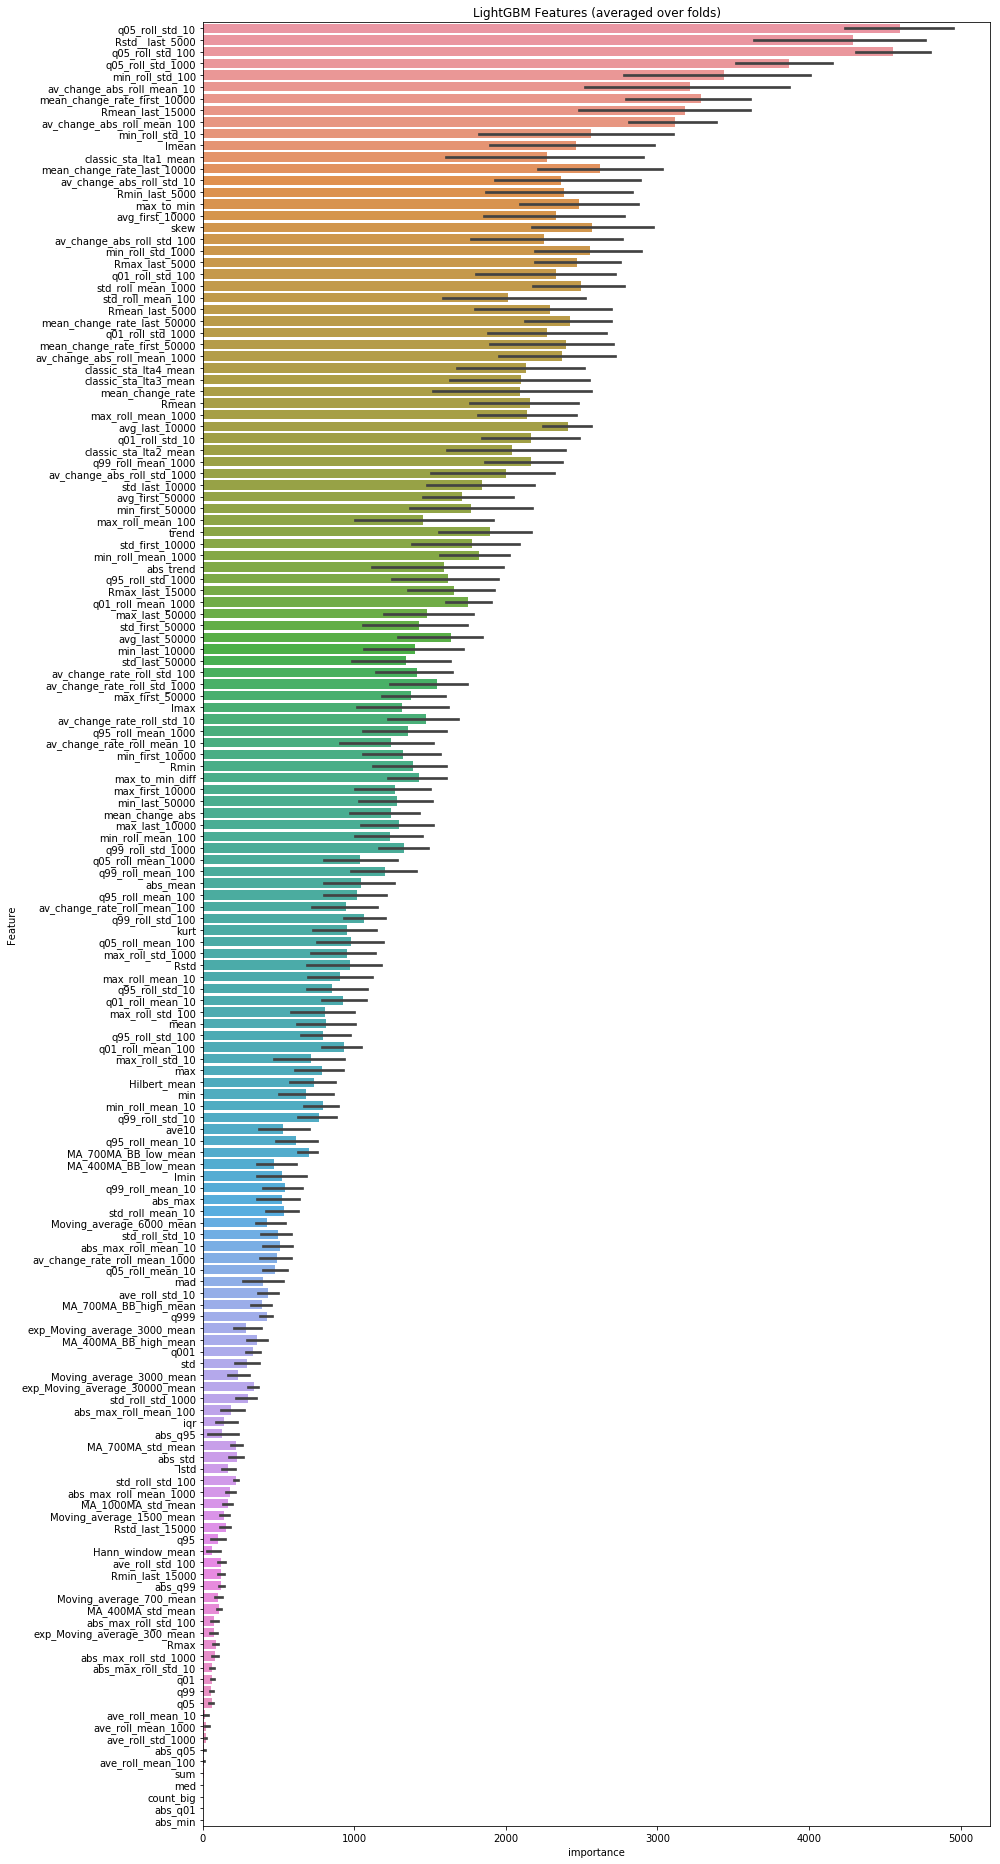

In [32]:
#Feature importance for model

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [33]:
#set the predicted time to failure in the submission file

submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True) #Score 1.553

In [ ]:
#For the SVM Model
submission2 = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [43]:
#SVR Model
svr = NuSVR()
svr.fit(scaled_train_X, train_y.values.flatten())
y_pred = svm.predict(scaled_train_X)

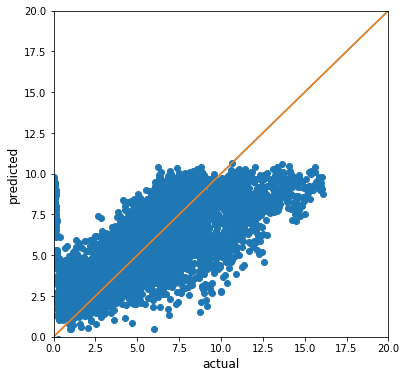

In [44]:
plt.figure(figsize=(6, 6))
plt.scatter(train_y.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [45]:
score = mean_absolute_error(train_y.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.016


In [48]:
X_test_scaled_2 = scaler.transform(test_X)
submission2['time_to_failure'] = svr.predict(X_test_scaled_2)
submission2.to_csv('svr/submission.csv') #Score 1.571